### Preparação do ambiente

Este projeto demanda a instalação dos pacotes **numpy, matplotlib, pyglet e gym[all]**

### Preâmbulo do projeto

Importação de todos pacotes necessários

In [1]:
import gym, math, tqdm, numpy as np, matplotlib.pyplot as plt

### Inicialização do ambiente e das variáveis

Nos exercícios anteriores, CartPole e MountainCar, as ações eram um valor discreto sempre. No caso do CartoPole era empurrar pra esquerda ou pra direita. No MountainCar era empurrar pra esquerda, pra direita ou não empurrar. Não havia como "dosar" o empurrão, ou tinha, ou não tinha.

No caso do Pendulum, só tem uma ação, porém, essa ação é um valor entre -2,0 e 2,0, ou seja, é um valor contínuo dentro do intervalo. Precisa "dosar" esse torque porque senão o pêndulo pode nunca convergir para a posição de repouso, a saber, de pé a 90 graus. Com a variável "size_ac" escolhe-se o tamanho da discretização deste intervalo -2,0 a 2,0. Claro que um número maior permitirá um ajuste mais afinado do modelo, mas também consumirá mais recurso computacional, ocupando memória. A variável "discrete_ac" é o vetor onde vai colocar cada valor para o torque. Por exemplo, suponhamos um "size_ac" de tamanho 3. Neste caso, "discrete_ac[3]" armazenará os valores "-2 0 2". Este vetor é empregado no método "discrete_action()".

In [2]:
env_name = "Pendulum-v1"
env = gym.make(env_name)
num_eps = 3000
epsilon, min_epsilon = 0.0, 0.1
learning_rate, min_learning_rate = 0.0, 0.53
discount_factor = 0.95
dec = 15

# Essa variável é apenas para discretizar a observação do ambiente.
discrete_st = [20, 20, 20]

# Estas variáveis são usadas para discretização do torque.
size_ac = 20
discrete_ac = [size_ac]
lower_st = [-1.0, -1.0, -8.0]
upper_st = [1.0, 1.0, 8.0]
lower_ac = [-2.0]
upper_ac = [2.0]

# A QTable neste problema será uma composição entre 2 listas.
# A lista com as observações do ambiente e outra lista dos torques q serem empregados no pêndulo
qtable = np.zeros(discrete_st + discrete_ac)

/home/wasf84/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wasf84/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
### TESTE

#np.random.randint(size_ac)], [np.argmax(qtable[discrete_state(env.reset())])]

### Métodos que serão empregados na geração da QTable

In [4]:
def choose_action(state):
    """
        O fator aleatório para melhorar o aprendizado
    """
    if (np.random.random() < epsilon):
        # Aqui uma alteração importante em relação aos trabalhos realizados anteriormente
        #    retornará um número aleatório de 0 até 'size_ac' que então será buscado no 'discrete_ac'.
        return [np.random.randint(size_ac)]
    else:
        return [np.argmax(qtable[state])]
# ---------------------------------------------------------------------#
def discrete_state(state):
    """
        Recebe um espaço de observação (observation space) e o discretiza
    """
    d = list()

    for i in range(len(state)):
        stepsize = (state[i] + abs(lower_st[i])) / (upper_st[i] - lower_st[i])
        new_state = int(round((discrete_st[i] - 1) * stepsize))
        new_state = min(discrete_st[i] - 1, max(0, new_state))
        d.append(new_state)

    return tuple(d)
# ---------------------------------------------------------------------#
def discrete_action(action):
    """
        Recebe ações (action space) e o discretiza
    """
    d = list()

    for i in range(len(action)):
        stepsize = (action[i] + abs(lower_ac[i])) / (upper_ac[i] - lower_ac[i])
        new_action = int(round((discrete_ac[i] - 1) * stepsize))
        new_action = min(discrete_ac[i] - 1, max(0, new_action))
        d.append(new_action)

    return tuple(d)
# ---------------------------------------------------------------------#
def continuous_action(idx):
    """
        Recebe um índice que retornara a posição do vetor "discrete_ac" com o valor contínuo da ação naquela posição.
    """
    d = list()

    for i in range(len(idx)):
        stepsize = idx[i] / (discrete_ac[i] - 1)
        new_action = lower_ac[i] + stepsize * (upper_ac[i] - lower_ac[i])
        d.append(new_action)

    return tuple(d)
# ---------------------------------------------------------------------#
def get_epsilon(ep):
    # vai reduzindo o epsilon para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir alguma aleatoriedade
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_epsilon, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def get_learning_rate(ep):
    # vai reduzindo a taxa de aprendizagem para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir algum aprendizado
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_learning_rate, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def update_qtable(state, action, reward, new_state):
    # isso está no Google Colab da disciplina
    qtable[state][action] += learning_rate * (reward + discount_factor * np.max(qtable[new_state]) - qtable[state][action])
# ---------------------------------------------------------------------#

In [5]:
### TESTE

#test = discrete_action([1.9])
#print(test)

#for x in np.linspace(-2, 2, 10):
#    print(x, continuous_action(discrete_action([x])))

#env.reset()

### Treinamento

In [6]:
# usado para plotar o gráfico de aprendizado
tr = []

for ep in tqdm.tqdm(range(num_eps)):
    current_state = discrete_state(env.reset())

    learning_rate = get_learning_rate(ep)
    epsilon = get_epsilon(ep)
    done = False

    # usado para plotar o gráfico de aprendizado
    r = []

    while not done:
        idx_disc_ac = choose_action(current_state)
        action = continuous_action(idx_disc_ac)
        observation, reward, done, _ = env.step(action)
        new_state = discrete_state(observation)
        update_qtable(current_state, idx_disc_ac, reward, new_state)
        current_state = new_state
        r.append(reward)

    env.close()
    tr.append(sum(r))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:57<00:00, 52.36it/s]


### Gráfico da aprendizagem

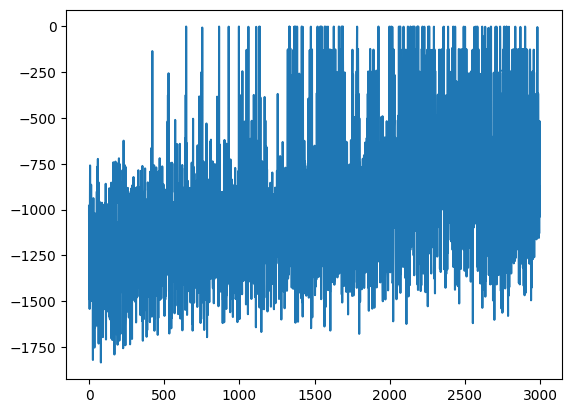

In [7]:
plt.plot(tr)

### Execução

In [8]:
tr = []     # usado para plotar o histograma
i = 0       # macete para renderizar alguns episodios

# executando sempre para 10% de passos sobre o número total de episódios usados para treinamento
for _ in tqdm.tqdm(range(int(num_eps * 0.1))):
    
    # ambiente a ser avaliado
    env_t = gym.make(env_name)
    
    # usado para plotar o gráfico de aprendizado
    r = []

    done = False

    # estado atual
    cs = discrete_state(env_t.reset())

    while not done:
        
        # Renderizar os ultimos 5 episodios
        if i >= (int(num_eps * 0.1) - 5):
            env_t.render()

        disc_ac = [np.argmax(qtable[cs])]
        action = continuous_action(disc_ac)
        obs, reward, done, _ = env_t.step(action)
        new_state = discrete_state(obs)
        cs = new_state
        r.append(reward)
        
    i += 1
    env_t.close()
    tr.append(sum(r))

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 293/300 [00:04<00:00, 68.68it/s]/home/wasf84/.local/lib/python3.10/site-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.45it/s]


### Histograma da execução

(array([35., 10.,  9., 13., 74., 69., 54., 24.,  7.,  5.]),
 array([-1639.89680097, -1489.39188034, -1338.8869597 , -1188.38203907,
        -1037.87711843,  -887.3721978 ,  -736.86727716,  -586.36235653,
         -435.85743589,  -285.35251525,  -134.84759462]),
 <BarContainer object of 10 artists>)

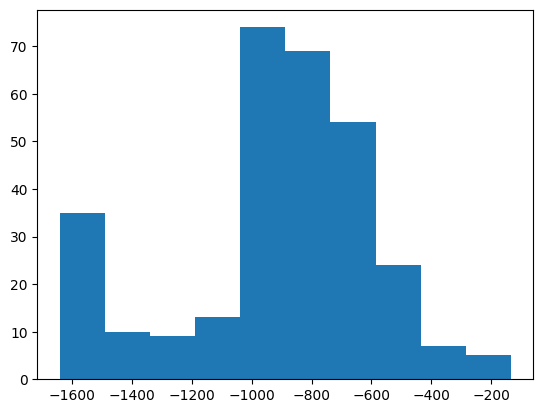

In [9]:
plt.hist(tr)